In [9]:
import rampy as rp
import matplotlib.pyplot as plt
import pickle
import lmfit
from lmfit.models import LorentzianModel
import peakutils
import shoyu

In [6]:
# import data dict
shoyu_data_dict = pickle.load(open('raman_spectra/shoyu_data_dict.p', 'rb'))
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

In [13]:
data = shoyu_data_dict['CARBON DIOXIDE']

[(621.262686, 0.5349999999999999),
 (651.636613, 0.6970000000000001),
 (670.32826, 0.9308),
 (725.234974, 0.667),
 (2262.622963, 0.2815),
 (2281.31461, 0.33899999999999997),
 (2303.510942, 0.863),
 (2326.875501, 0.982),
 (3592.0663765, 0.3398),
 (3620.1038475, 0.38770000000000004),
 (3696.0386642500002, 0.41700000000000004),
 (3715.89854, 0.511)]

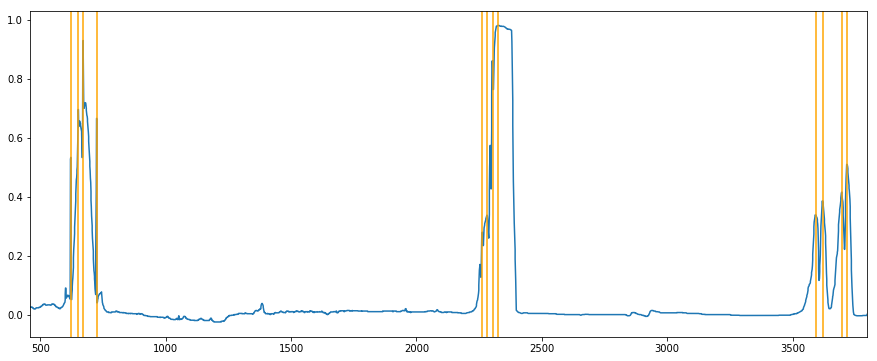

In [14]:
# just looking at the first 4 peaks
x = data['x']
y = data['y']

indexes = peakutils.indexes(y, thres=0.3, min_dist=10)

plt.figure(figsize=(15,6))
plt.plot(x, y)
plt.xlim(min(x), max(x))
# plt.ylim(0, 1.05)

for i in indexes:
    peak_index = x[i]
    plt.axvline(x=peak_index, color='orange')
indexes

peaks = []
for i in indexes:
    peak = (x[i], y[i])
    peaks.append(peak)
peaks

In [15]:
# assign lorentzian parameters
peaks = peaks
peak_list = []
for i in range(len(peaks)):
    prefix = 'p{}_'.format(i+1)
    peak = LorentzianModel(prefix=prefix)
    if i == 0:
        pars = peak.make_params()
    else:
        pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks[i][0], vary=True, min=(peaks[i][0]-10), max=(peaks[i][0]+10))
    pars[prefix+'height'].set(peaks[i][1], vary=True)
    pars[prefix+'sigma'].set(min=0, max=500)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    if i == 0:
        mod = peak_list[i]
    else:
        mod = mod + peak_list[i]

In [16]:
# fit model
init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_')) + Model(lorentzian, prefix='p9_')) + Model(lorentzian, prefix='p10_')) + Model(lorentzian, prefix='p11_')) + Model(lorentzian, prefix='p12_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8638
    # data points      = 3573
    # variables        = 48
    chi-square         = 8.75109926
    reduced chi-square = 0.00248258
    Akaike info crit   = -21384.8100
    Bayesian info crit = -21088.1143
[[Variables]]
    p1_sigma:       0.11099031 (init = 1)
    p1_center:      620.682058 (init = 621.2627)
    p1_amplitude:   4.09651851 (init = 1)
    p1_fwhm:        0.22198063 == '2.0000000*p1_sigma'
    p1_height:      0.53500000 (init = 0.535)
    p2_sigma:       1

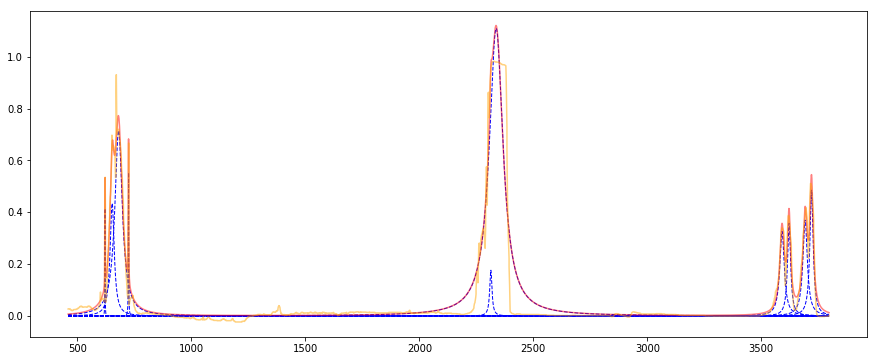

In [17]:
fig = plt.figure(figsize=(15,6))

plot_components = True
if plot_components:
    comps = out.eval_components(x=x)
    for i in range(len(peaks)):
        prefix = 'p{}_'.format(i+1) 
        plt.plot(x, comps[prefix], 'b--', linewidth=1)

# plt.plot(x, init, 'k--')
plt.plot(x, out.best_fit, 'r-', alpha=0.5)
plt.plot(x, y, 'orange', alpha=0.5)


plt.show()

In [ ]:
out.values['p1_fwhm']